In [3]:
%load_ext autoreload
%autoreload 2

In [1]:
import datetime
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns
from time import perf_counter

from tst import Transformer
import os
import pandas as pd
import torch.nn as nn

# from src.dataset import OzeDataset
# from src.utils import compute_loss
# from src.utils import preprocess
# from src.visualization import map_plot_function, plot_values_distribution, plot_error_distribution, plot_errors_threshold, plot_visual_sample

In [4]:
path = 'E:/S2S data sample/'


us_mask = pd.DataFrame(pd.read_hdf(path + 'us_mask.h5'))
# This block is to put all nearby sst data together in time order
# And also transform data into time order (single location\)
y_samp = pd.Series()
X_total = []

# !!! 2014-2019

for i in range(2014,2019):
    print('precip.'+str(i)+'.h5')
    name_precip = 'precip.'+str(i)+'.h5'
    name_sst = 'sst.'+str(i)+'.h5' 
    name_hgt = 'hgt500.'+str(i)+'.h5'
    name_rhum = 'rhum.sig995.'+str(i)+'.h5'
    name_tmp2m = 'tmp2m.'+str(i)+'.h5'
    fileloc_precip = path + name_precip
    fileloc_sst = path + name_sst
    fileloc_hgt = path + name_hgt
    fileloc_rhum = path + name_rhum
    fileloc_tmp2m = path + name_tmp2m
    precip = pd.DataFrame(pd.read_hdf(fileloc_precip)).reset_index() # precipitation
    precip.columns = ['lat', 'lon', 'start_date', 'precip']
    sst = pd.DataFrame(pd.read_hdf(fileloc_sst)).reset_index() # Daily sea surface temperature
    sst.columns = ['lat', 'lon', 'start_date', 'sst']
    hgt = pd.DataFrame(pd.read_hdf(fileloc_hgt)).reset_index() # Daily geopotential height at 10mb and 500mb
    hgt.columns = ['lat', 'lon', 'start_date', 'hgt']
    rhum = pd.DataFrame(pd.read_hdf(fileloc_rhum)).reset_index() # Daily relative humidity near the surface
    rhum.columns = ['lat', 'lon', 'start_date', 'rhum']
    tmp2m = pd.DataFrame(pd.read_hdf(fileloc_tmp2m)).reset_index() # Daily average temperature at 2 meters
    tmp2m.columns = ['lat', 'lon', 'start_date', 'tmp2m']
    print('original', tmp2m.shape)
    
    precip = pd.merge(precip, us_mask, on=['lat','lon'])
    hgt = pd.merge(hgt, us_mask, on=['lat','lon'])
    rhum = pd.merge(rhum, us_mask, on=['lat','lon'])
    tmp2m = pd.merge(tmp2m, us_mask, on=['lat','lon'])
    print('after merge', tmp2m.shape)
    
    hgt = np.reshape(hgt[(hgt['lat']==25.25) & (hgt['lon']==279.25)].hgt.to_numpy(),(-1,1))
    rhum = np.reshape(rhum[(rhum['lat']==25.25) & (rhum['lon']==279.25)].rhum.to_numpy(),(-1,1))
    tmp2m = np.reshape(tmp2m[(tmp2m['lat']==25.25) & (tmp2m['lon']==279.25)].tmp2m.to_numpy(),(-1,1))
    print('one location', tmp2m.shape)
    
    y_samp = y_samp.append(precip[precip['lat']==25.25].precip,ignore_index=True)
    
    if i%4 == 0:
        days = 366
    else:
        days = 365
    temp = sst #sst[(sst['lat']>=24.25) & (sst['lat']<=26.25) & (sst['lon']>=278.25) & (sst['lon']<=280.25)]
    print(temp.shape)
    sst_samp = temp.sst.reset_index().sst.to_numpy()
    print(sst_samp.shape)
    size = int(len(sst_samp)/days)
    sst_samp = np.reshape(sst_samp,(size, days)).transpose() # days as rows, different locations as columns
    all_features = np.concatenate((sst_samp,hgt,rhum,tmp2m),axis=1)
    print('all_features', all_features.shape)
    X_total.append(all_features)
    
X_size = X_total[0].shape[1]
X_samp = np.zeros((1,X_size)) #  For concatenating all data
print(X_samp.shape)
for i in range(len(X_total)):
    X_samp = np.concatenate((X_samp,X_total[i]),axis = 0)
X_samp = X_samp[1:]
print(X_samp.shape)

<ipython-input-4-def6ad68051a>:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_samp = pd.Series()


precip.2014.h5
original (1201945, 4)


KeyboardInterrupt: 

In [3]:
sst_samp.shape

(365, 169727)

In [4]:
X_copy = X_samp.copy()
y_copy = y_samp.copy()


In [547]:
X_samp = X_copy.copy()
y_samp = y_copy.copy()
target = 'precip'

y_samp = X_copy[:,X_copy.shape[1]-1].copy()
X_samp[:,X_copy.shape[1]-1] = y_copy.copy()
target = 'tmp2m'

In [548]:
X_samp.shape

(1826, 169730)

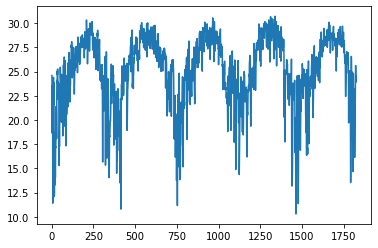

In [549]:
plt.plot(y_samp)

In [550]:
avg_window = 14
y_movavg = []
X_movavg = []
for i in range(y_samp.shape[0]-avg_window):
    y_avg = np.mean(y_samp[i:i+avg_window])
    y_movavg.append(y_avg)
    X_avg = np.mean(X_samp[i:i+avg_window],axis=0)
    X_movavg.append(X_avg)
y_movavg = np.array(y_movavg)
X_movavg = np.array(X_movavg)
y_samp = y_movavg
X_samp = X_movavg

In [551]:
X_samp.shape

(1812, 169730)

In [552]:
X = X_samp.copy()
y = y_samp.copy()

In [553]:
train_test_split = 0.8
test_size = int((1-train_test_split)*y_samp.shape[0])
X_train = X[:-test_size]
X_test = X[-test_size:]
y_train = y[:-test_size]
y_test = y[-test_size:]

In [554]:
y_train = np.reshape(y_train,(-1,1))  #  Matching dimension for concatenating X and y
y_test = np.reshape(y_test,(-1,1)) 
# train_data_array = np.concatenate((X_train,y_train),axis=1)
# train_data = torch.FloatTensor(train_data_array)
# y_train = torch.FloatTensor(y_train)

In [555]:
X_train.shape

(1450, 169730)

In [556]:
# X_train[169730]

In [557]:
y_train.shape

(1450, 1)

In [543]:
# z-score for LSTM

mean = np.mean(y_train)
std = np.std(y_train)
y_train = (y_train-mean)/std

X_train_mean_0_169727 = np.max(X_train[:,0:169727])
X_train_std_0_169727 = np.min(X_train[:,0:169727])
X_train[:,0:169727] = (X_train[:,0:169727] - X_train_mean_0_169727)/ X_train_std_0_169727

X_train_mean_169727 = np.mean(X_train[:,169727])
X_train_std_169727 = np.std(X_train[:,169727])
X_train[:,169727] = (X_train[:,169727] - X_train_mean_169727)/X_train_std_169727

X_train_mean_169728 = np.mean(X_train[:,169728])
X_train_std_169728 = np.std(X_train[:,169728])
X_train[:,169728] = (X_train[:,169728] - X_train_mean_169728)/X_train_std_169728

X_train_mean_169729 = np.mean(X_train[:,169729])
X_train_std_169729 = np.std(X_train[:,169729])
X_train[:,169729] = (X_train[:,169729] - X_train_mean_169729)/X_train_std_169729

In [544]:
y_test = (y_test -mean)/std

X_test[:,0:169727] = (X_test[:,0:169727] - X_train_mean_0_169727)/ X_train_std_0_169727
X_test[:,169727] = (X_test[:,169727] - X_train_mean_169727)/X_train_std_169727
X_test[:,169728] = (X_test[:,169728] - X_train_mean_169728)/ X_train_std_169728
X_test[:,169729] = (X_test[:,169729] - X_train_mean_169729)/X_train_std_169729

In [545]:
print(y_train.mean(), y_train.std())
# print(X_train.mean(), X_train.std())

6.860412621132002e-17 1.0


In [558]:
# use for TRANSFORMER!
M = np.max(y_train)
m = np.min(y_train)
y_train = (y_train -m)/(M - m)

X_train_max_0_169727 = np.max(X_train[:,0:169727])
X_train_min_0_169727 = np.min(X_train[:,0:169727])
X_train[:,0:169727] = (X_train[:,0:169727] - np.min(X_train[:,0:169727]))/ (np.max(X_train[:,0:169727]) - np.min(X_train[:,0:169727]))

X_train_max_169727 = np.max(X_train[:,169727])
X_train_min_169727 = np.min(X_train[:,169727])
X_train[:,169727] = (X_train[:,169727] - np.min(X_train[:,169727]))/(np.max(X_train[:,169727]) - np.min(X_train[:,169727]))

X_train_max_169728 = np.max(X_train[:,169728])
X_train_min_169728 = np.min(X_train[:,169728])
X_train[:,169728] = (X_train[:,169728] - np.min(X_train[:,169728]))/(np.max(X_train[:,169728]) - np.min(X_train[:,169728]))

X_train_max_169729 = np.max(X_train[:,169729])
X_train_min_169729 = np.min(X_train[:,169729])
X_train[:,169729] = (X_train[:,169729] - np.min(X_train[:,169729]))/(np.max(X_train[:,169729]) - np.min(X_train[:,169729]))

# X = X_samp.copy()
# y = y_samp.copy()

In [559]:
X_train_max_0_169727

36.014642170497346

In [560]:
print(y_train.max(), y_train.min())
print(X_train.max(), X_train.min())

1.0 0.0
1.0 0.0


In [561]:
y_test = (y_test -m)/(M - m)

In [562]:
X_test[:,0:169727] = (X_test[:,0:169727] - X_train_min_0_169727)/ (X_train_max_0_169727 - X_train_min_0_169727)
X_test[:,169727] = (X_test[:,169727] - X_train_min_169727)/(X_train_max_169727 - X_train_min_169727)
X_test[:,169728] = (X_test[:,169728] - X_train_min_169728)/ (X_train_max_169728 - X_train_min_169728)
X_test[:,169729] = (X_test[:,169729] - X_train_min_169729)/(X_train_max_169729 - X_train_min_169729)

In [563]:
print(y_test.max(), y_test.min())
print(X_test.max(), X_test.min())

0.9457259191180264 0.0913835395672233
0.965439690968835 -0.14097714415013957


Use after normalization

In [564]:
train_data_array = np.concatenate((X_train,y_train),axis=1)

In [565]:
train_data_array.shape

(1450, 169731)

In [566]:
from sklearn.decomposition import PCA

In [567]:
sst_data_train = train_data_array[:, 0:169727]
sst_data_test = X_test[:, 0:169727]

In [568]:
sst_data_train.shape

(1450, 169727)

In [569]:
num_pc = 1
pca = PCA(num_pc)
sst_data_train_500 = pca.fit_transform(sst_data_train)

In [570]:
sst_data_train_500.shape

(1450, 1)

In [571]:
sst_data_test_500 = pca.transform(sst_data_test)

In [572]:
sst_data_test_500.shape

(362, 1)

In [573]:
train_data_array[:, -4:].shape

(1450, 4)

In [574]:
a = [1,2, 3, 4, 5]
a = np.array(a)
a[-2:]

array([4, 5])

In [575]:
# create new X and Y with pca features 

train_data_array_new = np.concatenate((sst_data_train_500, train_data_array[:, -4:]), axis=1)

In [576]:
train_data_array_new.shape

(1450, 5)

In [577]:
test_data_new = np.concatenate((sst_data_test_500, X_test[:, -3:]), axis=1)
test_data_new.shape

(362, 4)

In [578]:
y_train[:3]

array([[0.35364852],
       [0.31931425],
       [0.25282873]])

In [579]:
train_data_array_new[:3, -1]

array([0.35364852, 0.31931425, 0.25282873])

In [580]:
train_data = torch.FloatTensor(train_data_array_new)
y_train = torch.FloatTensor(y_train)

In [581]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data = train_data.to(device)
y_train = y_train.to(device)

In [582]:
device

device(type='cuda')

In [583]:
def create_sequence(input_data, train_window, pred_window):  #  Create sequences of observations for training
    seq = []
    L = len(input_data)
    feature_size = input_data[0].shape[0]
    print('feature_size', feature_size)
    for i in range(L - train_window-pred_window):
        train_seq = input_data[i:i+train_window]
        train_label = input_data[i+train_window+pred_window-1,feature_size-1] # get y_t+14
#         train_label = input_data[i + train_window + pred_window]
        seq.append((train_seq ,train_label))
        
    print('train_seq, train_label', train_seq.shape, train_label.shape)
    return seq

In [584]:
train_window = 90
pred_window = 28
train_seq = create_sequence(train_data, train_window, pred_window)

feature_size 5
train_seq, train_label torch.Size([90, 5]) torch.Size([])


In [585]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, num_layers=1, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(num_layers,1,self.hidden_layer_size),
                            torch.zeros(num_layers,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        out = torch.sigmoid(predictions)
        return out[-1]

In [586]:
X_size = train_data_array_new.shape[1]-1
X_size

4

In [602]:
model = LSTM(input_size=X_size+1, hidden_layer_size=100, num_layers=1, output_size=1).to(device) # 2 features from X_obs and 1 from y_obs
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [603]:
epochs = 100
#  Training the model
t0 = perf_counter()

for i in range(epochs):
    for seq, labels in train_seq:
        optimizer.zero_grad() # num layers, batch size, hidden dim
        model.hidden_cell = (torch.zeros(model.num_layers, 1, model.hidden_layer_size).to(device),
                        torch.zeros(model.num_layers, 1, model.hidden_layer_size).to(device))

        pred = model(seq) # input shoulf be batch size, seq length, input dim
        labels = torch.reshape(labels,(-1,))  #  Match size to avoid warning
        single_loss = loss_function(pred, labels)
        single_loss.backward()
        optimizer.step()   
                
    if i%10 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
#     print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
t1 = perf_counter()
train_time = t1 - t0
print(f'Total training time: {train_time}')

epoch:   1 loss: 0.00612589
epoch:  11 loss: 0.00039708
epoch:  21 loss: 0.01032388
epoch:  31 loss: 0.00998592
epoch:  41 loss: 0.01349311
epoch:  51 loss: 0.00431490
epoch:  61 loss: 0.01299427
epoch:  71 loss: 0.00309329
epoch:  81 loss: 0.00074107
epoch:  91 loss: 0.00018216
epoch:  99 loss: 0.0001656664
Total training time: 379.78913680000005


In [604]:
# Predicting t+1
test_data = np.concatenate((test_data_new, y_test),axis=1)

train_test_total = np.concatenate((train_data_array_new, test_data))

model.eval()
num_pred = 1 #  Number of prediction forward, i.e. tau
res = np.zeros(train_window).tolist()
#  Predicting y using X_test and y_test
for i in range(train_test_total.shape[0]-train_window):
    for j in range(num_pred):
        seq = torch.FloatTensor(train_test_total[i:i+train_window]).to(device)
        #print(seq)
        with torch.no_grad():
            model.hidden = (torch.zeros(model.num_layers, 1, model.hidden_layer_size).to(device),
                            torch.zeros(model.num_layers, 1, model.hidden_layer_size).to(device))
            #print(model(seq))
            pred = model(seq).cpu()
            #print(len(test_inputs))
            res.append(pred)
res = np.array(res)

In [605]:
y_samp.shape

(1812,)

In [606]:
# y_test

In [607]:
y_normed = np.concatenate((y_train.cpu(), y_test))

r-sq on train: 0.3980426334462237
r-sq on test: 0.12260427784725247
cosine_similarity on train: [[0.96677873]]
cosine_similarity on test: [[0.94153798]]


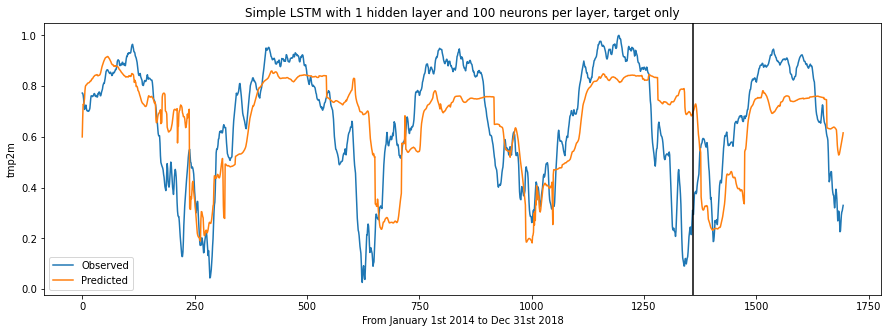

In [608]:
# train window 90 
y_train = y_train.cpu()

print('r-sq on train:', r2_score(y_normed[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_normed[-test_size:],  res[-test_size-pred_window:-pred_window]))
print('cosine_similarity on train:', cosine_similarity(y_normed[train_window+pred_window:-test_size].reshape((1,-1)), res[train_window:-test_size-pred_window].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_normed[-test_size:].reshape((1,-1)),  res[-test_size-pred_window:-pred_window].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_normed[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Simple LSTM with 1 hidden layer and 100 neurons per layer, target only')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');
testname = 'results/LSTM_PCA_'+str(num_pc)+'.png'
plt.savefig(testname)

In [594]:
from torch.utils.data import Dataset, DataLoader

class SeqDataset(Dataset):
    def __init__(self, seq_data, transform=None):
        
        self.seq_data = seq_data
        self.x = []
        self.y = []
        for i in range(len(self.seq_data)):
            self.x.append(self.seq_data[i][0])
            self.y.append(self.seq_data[i][1])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return (self.x[idx], self.y[idx])

    def __len__(self):
        return len(train_seq) #self._x.shape[0]

In [595]:
dataset_train = SeqDataset(train_seq)
dataloader_train = DataLoader(dataset_train,
                              batch_size=32,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )

In [596]:
d_input = train_data_array_new.shape[1] # From dataset
d_output = 1 # From dataset

attention_size = 8
LR = 1e-4 #1e-3
d_model = 64
q = 8 # Query size
v = 8 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
dropout = 0.2 # Dropout rate
# pe = 'original' # Positional encoding
chunk_mode = None
net = Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
                  dropout=dropout, chunk_mode=chunk_mode, pe='regular', pe_period=2, seq_length=90).to(device)
# net = nn.Sequential(Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
#                   dropout=dropout, chunk_mode=chunk_mode, pe=pe),
#                     nn.Flatten(),
#                     nn.Linear(30, 1),
#                    ).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = nn.MSELoss() #OZELoss(alpha=0.3)

In [597]:
y_label.shape

torch.Size([20, 1])

In [598]:
netout.shape

torch.Size([20, 1])

[Epoch 100/100]: 100%|██████████| 1332/1332 [00:01<00:00, 684.53it/s, loss=0.0085] 


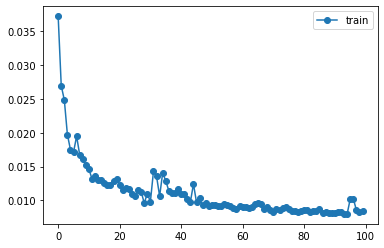

In [599]:
EPOCHS = 100
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)

for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(train_seq), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y_label) in enumerate(dataloader_train):
#             x = x.unsqueeze(0)
            y_label = y_label.view(-1,1)
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Compute loss
#             print(netout, y)
            loss = loss_function(y_label.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
                
#         scheduler.step()    
        train_loss = running_loss/len(dataloader_train)
#         print('pred, target', netout, y)
#         val_loss = compute_loss(net, dataloader_val, loss_function, device).item()
#         pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        pbar.set_postfix({'loss': train_loss})

        hist_loss[idx_epoch] = train_loss
#         hist_loss_val[idx_epoch] = val_loss

#         if val_loss < val_loss_best:
#             val_loss_best = val_loss
#             torch.save(net.state_dict(), model_save_path)
        
plt.plot(hist_loss, 'o-', label='train')
# plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
# print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

In [600]:
test_data = np.concatenate((test_data_new, y_test),axis=1)

train_test_total = np.concatenate((train_data_array_new, test_data))

net.eval()
num_pred = 1 #  Number of prediction forward, i.e. tau
res = np.zeros(train_window).tolist()
#  Predicting y using X_test and y_test
for i in tqdm(range(train_test_total.shape[0]-train_window)):
    for j in range(num_pred):
        seq = torch.FloatTensor(train_test_total[i:i+train_window]).to(device)
        seq = seq.unsqueeze(0)
        #print(seq)
        with torch.no_grad():
            #print(model(seq))
            pred = net(seq).cpu()
            #print(len(test_inputs))
            res.append(pred)
            
res = np.array(res)

100%|██████████| 1722/1722 [00:23<00:00, 72.93it/s]


r-sq on train: 0.8819550488085879
r-sq on test: 0.7275199166280548
cosine_similarity on train: [[0.9936558]]
cosine_similarity on test: [[0.98309625]]


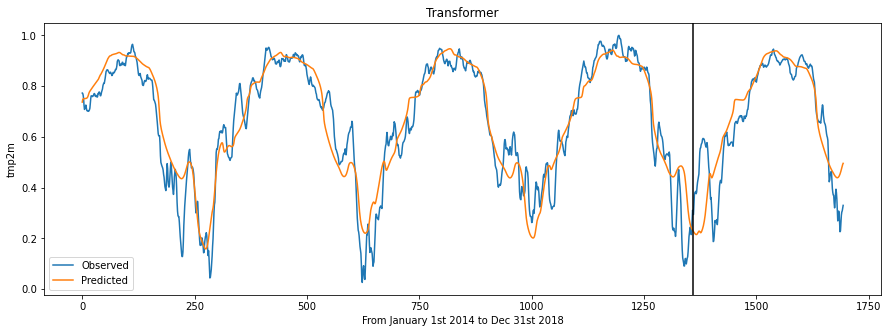

In [601]:
y_train = y_train.cpu()

print('r-sq on train:', r2_score(y_normed[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_normed[-test_size:],  res[-test_size-pred_window:-pred_window]))
print('cosine_similarity on train:', cosine_similarity(y_normed[train_window+pred_window:-test_size].reshape((1,-1)), res[train_window:-test_size-pred_window].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_normed[-test_size:].reshape((1,-1)),  res[-test_size-pred_window:-pred_window].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_normed[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');
testname = 'results/Transformer_PCA_'+str(num_pc)+'.png'
plt.savefig(testname)